In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras 
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras import models
from keras.models import Model


from sklearn.model_selection import TimeSeriesSplit

In [35]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5648826450246197816
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16183459840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 136616760110231364
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


# Data preprocessing

In [36]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BCJ_Hack/final_train.csv')

In [37]:
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BCJ_Hack/test_test.csv')

In [38]:
data.head()

,Регион,Anaplasma Phagocytophillum(кач) ДНК,Borrelia burgdorferi s.l (кач) ДНК,Borrelia miyamotoi (кач) ДНК,Ehrlichia muris/chaffeеnsis(кач) ДНК,Вирус клещевого энцефалита(кач) РНК,Anaplasma Phagocytophillum(кач) ДНК positive,Borrelia burgdorferi s.l (кач) ДНК positive,Borrelia miyamotoi (кач) ДНК positive,Ehrlichia muris/chaffeеnsis(кач) ДНК positive,Вирус клещевого энцефалита(кач) РНК positive,region all,epidemic_region,activity_level_of_mite,percentage_of_mite,density,mean_wage,Ev_znmean,Biomean,anthropmea,mean,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,Mnth,Day,region_code
0,Адыгея Респ,0.0,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,10.0,59.44,30991,647.99804,89.213187,38.071429,2969.252747,2019-07-30,34,19,0.0,14.5,7,2,02:47 AM,06:35 PM,05:03 AM,07:48 PM,16,27,27,26,7,13,59,0.3,1005,34,10,222,4,7,30,0
1,Адыгея Респ,0.0,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,10.0,59.44,30991,647.99804,89.213187,38.071429,2969.252747,2020-04-25,19,4,0.0,14.0,4,15,06:41 AM,09:39 PM,05:19 AM,07:17 PM,3,11,12,11,12,15,59,0.0,1009,19,10,90,8,4,25,0
2,Адыгея Респ,0.0,2.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,10.0,59.44,30991,647.99804,89.213187,38.071429,2969.252747,2020-05-19,21,10,0.0,14.5,5,11,03:35 AM,04:21 PM,04:47 AM,07:46 PM,8,15,17,15,22,14,65,0.0,1021,21,10,264,15,5,19,0
3,Адыгея Респ,0.0,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,10.0,59.44,30991,647.99804,89.213187,38.071429,2969.252747,2020-08-01,25,18,0.0,12.3,5,82,06:29 PM,02:22 AM,05:06 AM,07:45 PM,17,23,23,22,17,41,76,9.6,1006,25,9,257,10,8,1,0
4,Адыгея Респ,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,10.0,59.44,30991,647.99804,89.213187,38.071429,2969.252747,2020-08-17,28,12,0.0,14.0,6,1,02:54 AM,06:42 PM,05:25 AM,07:22 PM,4,20,20,20,18,5,37,0.0,1014,28,10,74,11,8,17,0


In [39]:
data = pd.concat([data, pd.get_dummies(data['region_code']).astype('int')], axis = 1)
test_data = pd.concat([test_data, pd.get_dummies(test_data['region_code']).astype('int')], axis = 1)
regions=test_data['Регион']

In [40]:
column_4_delit=['Регион','moonrise', 'moonset','sunrise', 'sunset', 'region_code','date_time']
column_4_delit_test=['Регион','moonrise', 'moonset','sunrise', 'sunset', 'region_code','date_time','date']

In [41]:
data.drop(column_4_delit,axis=1,inplace=True)
test_data.drop(column_4_delit_test,axis=1,inplace=True)

In [42]:
data.columns.to_list()

['Anaplasma Phagocytophillum(кач) ДНК',
 'Borrelia burgdorferi s.l (кач) ДНК',
 'Borrelia miyamotoi (кач) ДНК',
 'Ehrlichia muris/chaffeеnsis(кач) ДНК',
 'Вирус клещевого энцефалита(кач) РНК',
 'Anaplasma Phagocytophillum(кач) ДНК positive',
 'Borrelia burgdorferi s.l (кач) ДНК positive',
 'Borrelia miyamotoi (кач) ДНК positive',
 'Ehrlichia muris/chaffeеnsis(кач) ДНК positive',
 'Вирус клещевого энцефалита(кач) РНК positive',
 'region all',
 'epidemic_region',
 'activity_level_of_mite',
 'percentage_of_mite',
 'density',
 'mean_wage',
 'Ev_znmean',
 'Biomean',
 'anthropmea',
 'mean',
 'maxtempC',
 'mintempC',
 'totalSnow_cm',
 'sunHour',
 'uvIndex',
 'moon_illumination',
 'DewPointC',
 'FeelsLikeC',
 'HeatIndexC',
 'WindChillC',
 'WindGustKmph',
 'cloudcover',
 'humidity',
 'precipMM',
 'pressure',
 'tempC',
 'visibility',
 'winddirDegree',
 'windspeedKmph',
 'Mnth',
 'Day',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 

In [43]:
features = ['region all',
 'epidemic_region',
 'activity_level_of_mite',
 'percentage_of_mite',
 'density',
 'mean_wage',
 'Ev_znmean',
 'Biomean',
 'anthropmea',
 'mean',
 'maxtempC',
 'mintempC',
 'totalSnow_cm',
 'sunHour',
 'uvIndex',
 'moon_illumination',
 'DewPointC',
 'FeelsLikeC',
 'HeatIndexC',
 'WindChillC',
 'WindGustKmph',
 'cloudcover',
 'humidity',
 'precipMM',
 'pressure',
 'tempC',
 'visibility',
 'winddirDegree',
 'windspeedKmph',
 'Mnth',
 'Day',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66
]

target = [ 'Anaplasma Phagocytophillum(кач) ДНК',
          'Anaplasma Phagocytophillum(кач) ДНК positive',
          'Borrelia burgdorferi s.l (кач) ДНК',
          'Borrelia burgdorferi s.l (кач) ДНК positive', 
          'Borrelia miyamotoi (кач) ДНК',
          'Borrelia miyamotoi (кач) ДНК positive',
          'Ehrlichia muris/chaffeеnsis(кач) ДНК',
          'Ehrlichia muris/chaffeеnsis(кач) ДНК positive',
          'Вирус клещевого энцефалита(кач) РНК',    
          'Вирус клещевого энцефалита(кач) РНК positive'
]

In [44]:
len(features)

98

In [45]:
X = data[features]
y = data[target]
X_test = test_data[features]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_norm=scaler.fit_transform(X)
X_test_norm=scaler.transform(X_test)

In [46]:
X_norm.shape, X_test_norm.shape

((7744, 98), (1273, 98))

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6195, 98), (1549, 98), (6195, 10), (1549, 10))

# Net Architecture

In [48]:
input_data = Input(len(features))

dense_1 = Dense(200, activation='relu')(input_data)
dense_1 = Dropout(0.1)(dense_1)
dense_1 = Dense(50, activation='relu')(dense_1)
dense_1 = BatchNormalization()(dense_1)
dense_1 = Dense(10, activation='relu')(dense_1)

dense_2 = Dense(200, activation='LeakyReLU')(input_data)
dense_2 = Dropout(0.1)(dense_2)
dense_2 = Dense(50, activation='LeakyReLU')(dense_2)
dense_2 = BatchNormalization()(dense_2)
dense_2 = Dense(10, activation='LeakyReLU')(dense_2)


dense_3 = Dense(200, activation='tanh')(input_data)
dense_3 = Dropout(0.1)(dense_3)
dense_3 = Dense(50, activation='tanh')(dense_3)
dense_3 = BatchNormalization()(dense_3)
dense_3 = Dense(10, activation='tanh')(dense_3)



mid_1 = keras.layers.concatenate([dense_1, dense_2, dense_3], axis = 1)

# flat_1 = Flatten()(mid_1) 

dense_4 = Dense(1000, activation='relu')(mid_1)

output = Dense(len(target), activation='linear')(dense_4)


model = Model([input_data], output)

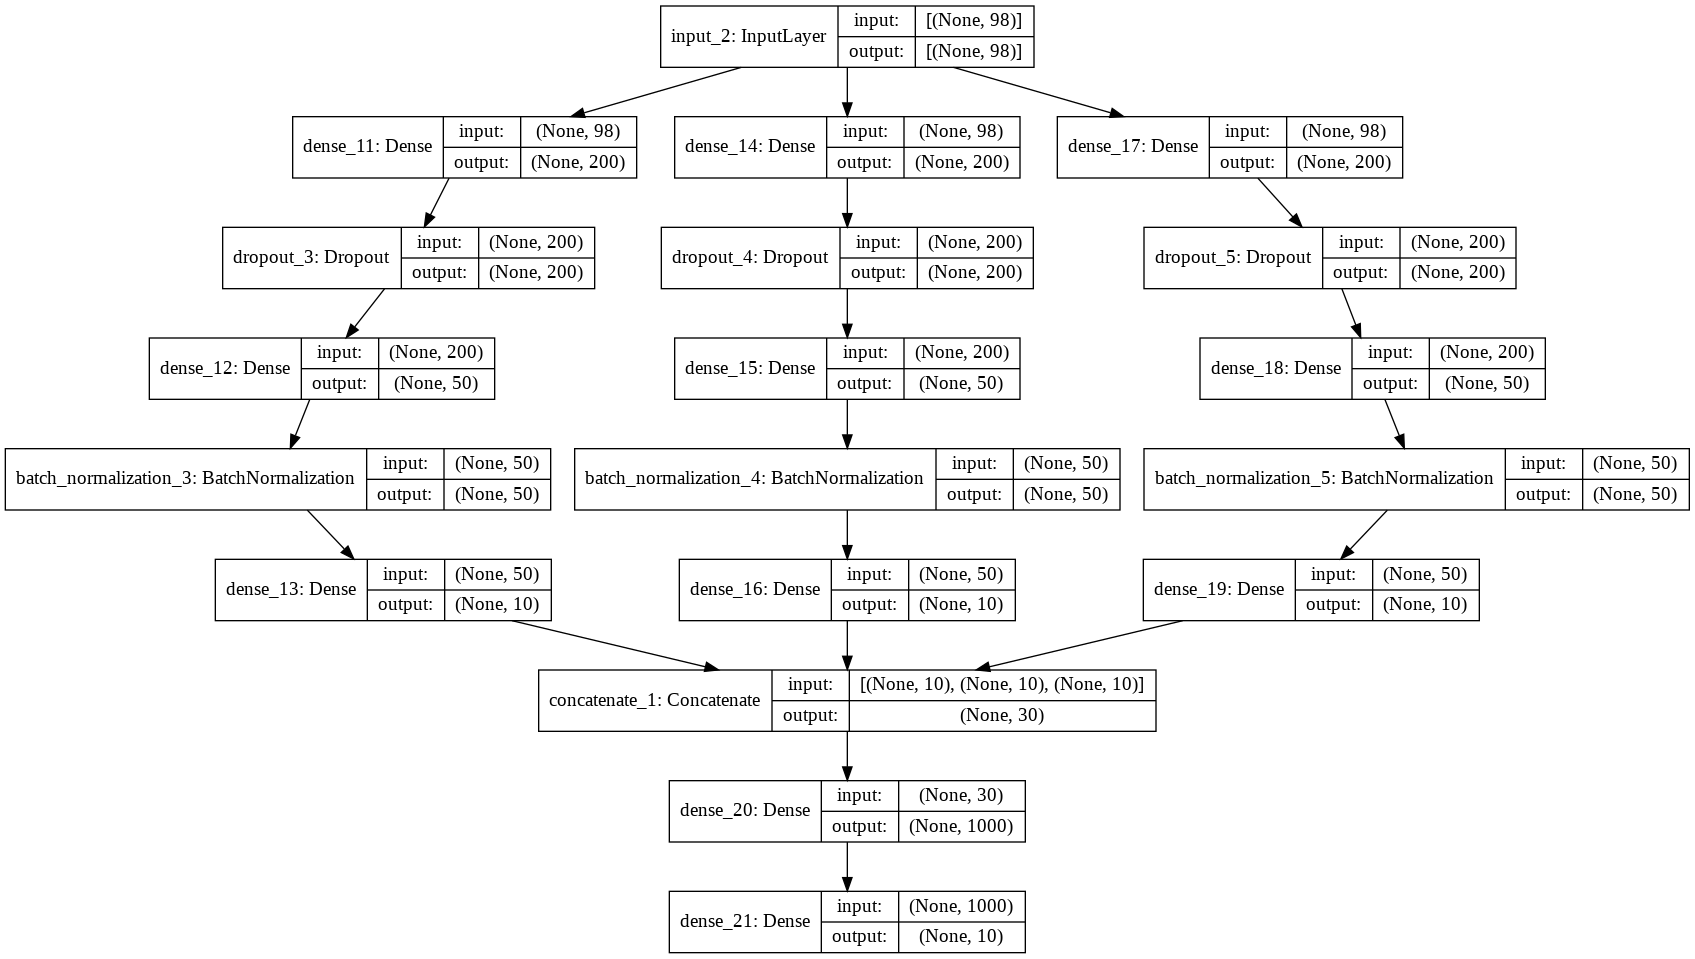

In [49]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [50]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 98)]         0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 200)          19800       input_2[0][0]                    
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 200)          19800       input_2[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 200)          19800       input_2[0][0]                    
____________________________________________________________________________________________

# Net Fit

In [51]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['mse','mae','mape'],
    loss='mae',
    )

In [52]:
history=model.fit(
    x=X_train,
    y=y_train,
    validation_data = (X_test, y_test),
    batch_size=700,
    epochs=2000,
    verbose=2,
    callbacks=None,
    initial_epoch=0,
    workers=-1,
)

Epoch 1/2000
9/9 - 3s - loss: 6.3452 - mse: 615.4407 - mae: 6.3452 - mape: 63170336.0000 - val_loss: 5.5983 - val_mse: 446.3918 - val_mae: 5.5983 - val_mape: 198532560.0000
Epoch 2/2000
9/9 - 0s - loss: 6.2986 - mse: 614.2308 - mae: 6.2986 - mape: 57936904.0000 - val_loss: 5.4782 - val_mse: 443.9749 - val_mae: 5.4782 - val_mape: 185162576.0000
Epoch 3/2000
9/9 - 0s - loss: 6.2602 - mse: 613.2318 - mae: 6.2602 - mape: 57184896.0000 - val_loss: 5.4443 - val_mse: 441.1525 - val_mae: 5.4443 - val_mape: 191398960.0000
Epoch 4/2000
9/9 - 0s - loss: 6.2233 - mse: 612.2100 - mae: 6.2233 - mape: 56419344.0000 - val_loss: 5.4459 - val_mse: 438.3487 - val_mae: 5.4459 - val_mape: 205926256.0000
Epoch 5/2000
9/9 - 0s - loss: 6.1869 - mse: 611.1823 - mae: 6.1869 - mape: 57185096.0000 - val_loss: 5.4575 - val_mse: 435.9703 - val_mae: 5.4575 - val_mape: 216755264.0000
Epoch 6/2000
9/9 - 0s - loss: 6.1511 - mse: 609.9205 - mae: 6.1511 - mape: 58627864.0000 - val_loss: 5.4719 - val_mse: 433.8708 - val_m

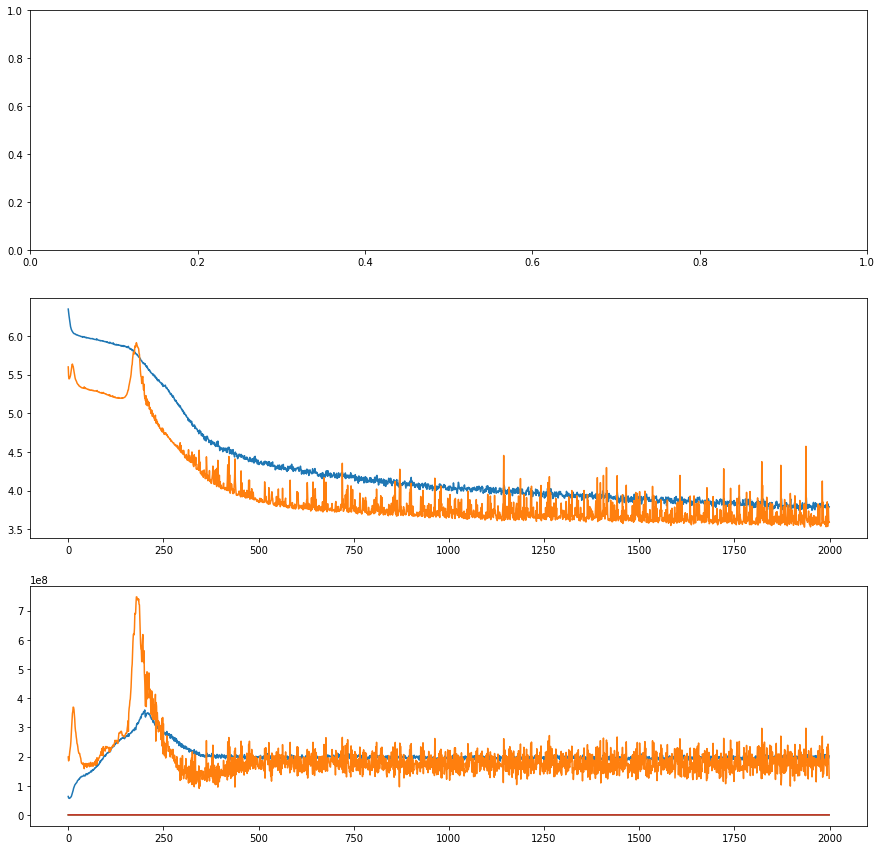

In [53]:
import matplotlib.pyplot as plt
fig, ax =plt.subplots(nrows=3, figsize=(15, 15))

#ax[1].set_yscale('log')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])

#ax[2].set_yscale('log')
ax[2].plot(history.history['mape'])
ax[2].plot(history.history['val_mape'])

#ax[2].set_yscale('log')
ax[2].plot(history.history['mse'])
ax[2].plot(history.history['val_mse'])

In [54]:
model.fit(
    x=X_norm,
    y=y,
    batch_size=700,
    epochs=2000,
    verbose=2,
    callbacks=None,
    initial_epoch=0,
    workers=-1,
)

Epoch 1/2000
12/12 - 1s - loss: 8.1092 - mse: 590.6335 - mae: 8.1092 - mape: 1266274944.0000
Epoch 2/2000
12/12 - 0s - loss: 5.4619 - mse: 370.9699 - mae: 5.4619 - mape: 515926752.0000
Epoch 3/2000
12/12 - 0s - loss: 4.9100 - mse: 330.2129 - mae: 4.9100 - mape: 338904448.0000
Epoch 4/2000
12/12 - 0s - loss: 4.6643 - mse: 292.7054 - mae: 4.6643 - mape: 319342720.0000
Epoch 5/2000
12/12 - 0s - loss: 4.4080 - mse: 256.1153 - mae: 4.4080 - mape: 301262944.0000
Epoch 6/2000
12/12 - 0s - loss: 4.2941 - mse: 248.6895 - mae: 4.2941 - mape: 282042432.0000
Epoch 7/2000
12/12 - 0s - loss: 4.1851 - mse: 241.9580 - mae: 4.1851 - mape: 266689632.0000
Epoch 8/2000
12/12 - 0s - loss: 4.1554 - mse: 239.2769 - mae: 4.1554 - mape: 260227264.0000
Epoch 9/2000
12/12 - 0s - loss: 4.0797 - mse: 228.7589 - mae: 4.0797 - mape: 260805680.0000
Epoch 10/2000
12/12 - 0s - loss: 4.0897 - mse: 233.4575 - mae: 4.0897 - mape: 260519248.0000
Epoch 11/2000
12/12 - 0s - loss: 3.9908 - mse: 223.0161 - mae: 3.9908 - mape: 

In [55]:
model.save('/content/drive/MyDrive/Colab Notebooks/BCJ_Hack/Model_EN/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/BCJ_Hack/Model_EN/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/BCJ_Hack/Model_EN/assets


# Net Predict & Submit

In [56]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Colab Notebooks/BCJ_Hack/Model_EN/')

In [80]:
preds = model.predict(X_test_norm)
pred_null=preds.copy()
pred_null[pred_null<0]=0
pred_null.shape

(1273, 10)

In [58]:
preds.shape

(1273, 10)

In [66]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BCJ_Hack/submission_example.csv')

In [68]:
idx=test.pop('Unnamed: 0')

In [82]:
submition=pd.DataFrame()
submit_w0=pd.DataFrame()
k=0
for i in test.columns:
  if i =='region':
    submition[i]=regions
    submit_w0[i]=regions
  else:
    submition[i]=preds[:,k]
    submit_w0[i]=pred_null[:,k]
    k+=1

In [83]:
submition.index=idx
submit_w0.index=idx

In [87]:
submit_w0.rename_axis(None, inplace=True)

In [88]:
submit_w0.to_csv('submit_w0.csv')

In [90]:
submission_path='/content/submit_w0.csv'

In [93]:
import requests
def submit_file(submission_path):
    files = {'file': (submission_path, open(submission_path,'rb'), 'text/x-spam')}
    TOKEN = '5fb14c62-3e29-4a01-a7c6-17e100dbe596'
    values = {'token': TOKEN}
    return requests.post('http://130.193.54.199:23030/', files=files, data=values)

res = submit_file(submission_path)
res.content

b'{\n  "daily_submits": 4, \n  "date": "2021-06-27 11:20:00", \n  "score": "to be announced", \n  "task_name": "invitro", \n  "team_name": "data_healers"\n}\n'